In [1]:
from tg.common.outfittery.delivery import SagemakerLogs
from datetime import datetime

SagemakerLogs.BUCKET = 'ps-data-science-sandbox'
SagemakerLogs.PROJECT_NAME = 'tsa'

I'm not happy with the quality in the real environment. Way too often it's false positive error detection. Hypothesis: it's because of the sentence length (I typically write with very long and complicated sentences).

Potentially, there is a room for the finer context in these long sentences.

First, remake experiments with the biggest networks with longer contexts

New default values (to count changes from):

```
epoch_count:int = 15,
batch_size: int = 20000,
mini_batch_size: int = 200,
mini_epoch_count: int = 4,
learning_rate: float = 0.1,
plain_context_length: int = 10,
plain_context_left_shift: float = 0.5,
plain_net_size = [20],
plain_network_mode = btm.ContextualNetworkType.Plain,
plain_context_reverse = False,
feature_allow_list = None
```

## LSTM

First, some experiment with LSTM and different PCLS. PCLS shifts context to the right. I thought that since LSTM is able to work with _reversed_ context, sure it's gonna work with shifted.

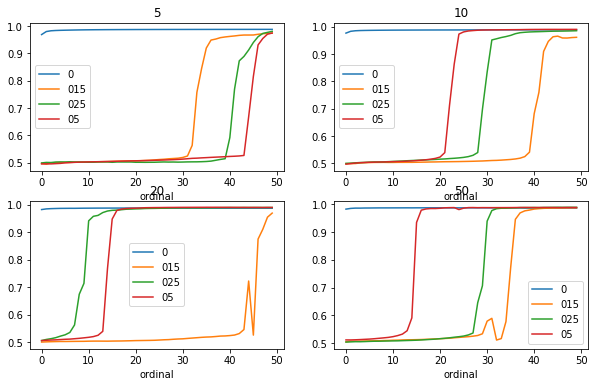

In [2]:
import re
job_ids = [
    'TSA-EC50-PCL25-PNS50-PCLS05-PNMLSTM-2022-06-04-19-16-04-596',
 'TSA-EC50-PCL25-PNS50-PCLS025-PNMLSTM-2022-06-04-19-15-46-846',
 'TSA-EC50-PCL25-PNS50-PCLS015-PNMLSTM-2022-06-04-19-15-29-226',
 'TSA-EC50-PCL25-PNS50-PCLS0-PNMLSTM-2022-06-04-19-15-13-355',
 'TSA-EC50-PCL25-PNS20-PCLS05-PNMLSTM-2022-06-04-19-14-57-519',
 'TSA-EC50-PCL25-PNS20-PCLS025-PNMLSTM-2022-06-04-19-14-39-718',
 'TSA-EC50-PCL25-PNS20-PCLS015-PNMLSTM-2022-06-04-19-14-22-550',
 'TSA-EC50-PCL25-PNS20-PCLS0-PNMLSTM-2022-06-04-19-14-05-604',
 'TSA-EC50-PCL25-PNS10-PCLS05-PNMLSTM-2022-06-04-19-13-48-721',
 'TSA-EC50-PCL25-PNS10-PCLS025-PNMLSTM-2022-06-04-19-13-32-118',
 'TSA-EC50-PCL25-PNS10-PCLS015-PNMLSTM-2022-06-04-19-13-15-291',
 'TSA-EC50-PCL25-PNS10-PCLS0-PNMLSTM-2022-06-04-19-12-58-452',
 'TSA-EC50-PCL25-PNS5-PCLS05-PNMLSTM-2022-06-04-19-12-42-130',
 'TSA-EC50-PCL25-PNS5-PCLS025-PNMLSTM-2022-06-04-19-12-25-662',
 'TSA-EC50-PCL25-PNS5-PCLS015-PNMLSTM-2022-06-04-19-12-09-387',
 'TSA-EC50-PCL25-PNS5-PCLS0-PNMLSTM-2022-06-04-19-11-52-578',
]
sl = SagemakerLogs(job_ids).load_from_s3()
from yo_fluq_ds import *
cdf = sl.get_metric_by_job('roc_auc_score_test')
for pns in Query.en(['5','10','20','50']).feed(fluq.with_plots(columns=2)):
    tdf = cdf[[c for c in cdf.columns if f'-PNS{pns.item}-' in c]]
    tdf.columns = [re.search('-PCLS([^-]+)-', c).group(1) for c in tdf.columns]
    tdf.plot(ax=pns.ax)

So indeed it works, but in a very unpredictable way. For PNS5, it's fine: first 0.15, then 0.25, then 0.5. For 10 it's different. Maybe it's random. So either I need to use LSTM with PCLS0 (ignoring the right context), or find another way to analyze shifted contexts (attention networks?)

## Plain networks

So for the time being, I'll stick to the plain networks

metric,iteration,loss,roc_auc_score_display,roc_auc_score_test
job_id,,,,
TSA-EC25-PCL25-PNS20-2022-06-04-18-52-11-821,24.0,0.023717,0.992100,0.989836
TSA-EC25-PCL21-PNS20-2022-06-04-18-51-21-146,24.0,0.024621,0.991813,0.989754
TSA-EC25-PCL21-PNS50-2022-06-04-18-51-36-096,24.0,0.023890,0.992120,0.989717
TSA-EC25-PCL25-PNS50-2022-06-04-18-52-30-030,24.0,0.023388,0.991932,0.989433
TSA-EC25-PCL15-PNS50-2022-06-04-18-50-51-501,24.0,0.025936,0.990920,0.989154
TSA-EC25-PCL21-PNS100-2022-06-04-18-51-51-464,24.0,0.025111,0.991231,0.988972
TSA-EC25-PCL15-PNS100-2022-06-04-18-51-07-003,24.0,0.026398,0.990748,0.988951
TSA-EC25-PCL25-PNS100-2022-06-04-18-52-45-896,24.0,0.024303,0.991157,0.988879
TSA-PCL7-PNS20-2022-06-05-10-37-58-189,14.0,0.033512,0.989656,0.988397


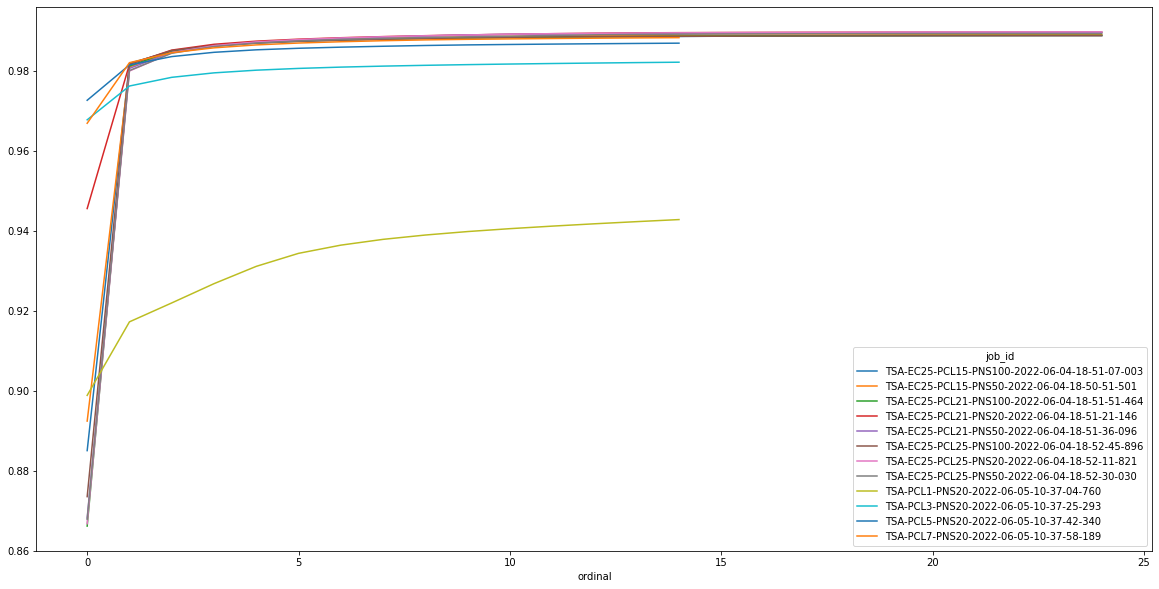

In [11]:
from matplotlib import pyplot as plt
job_ids = [
    'TSA-EC25-PCL25-PNS100-2022-06-04-18-52-45-896',
 'TSA-EC25-PCL25-PNS50-2022-06-04-18-52-30-030',
 'TSA-EC25-PCL25-PNS20-2022-06-04-18-52-11-821',
 'TSA-EC25-PCL21-PNS100-2022-06-04-18-51-51-464',
 'TSA-EC25-PCL21-PNS50-2022-06-04-18-51-36-096',
 'TSA-EC25-PCL21-PNS20-2022-06-04-18-51-21-146',
 'TSA-EC25-PCL15-PNS100-2022-06-04-18-51-07-003',
 'TSA-EC25-PCL15-PNS50-2022-06-04-18-50-51-501'
] + ['TSA-PCL7-PNS20-2022-06-05-10-37-58-189',
 'TSA-PCL5-PNS20-2022-06-05-10-37-42-340',
 'TSA-PCL3-PNS20-2022-06-05-10-37-25-293',
 'TSA-PCL1-PNS20-2022-06-05-10-37-04-760']
sl = SagemakerLogs(job_ids).load_from_s3()
_, ax = plt.subplots(1,1,figsize=(20,10))
sl.get_metric_by_job('roc_auc_score_test').plot(ax=ax)

sl.get_last_values().sort_values('roc_auc_score_test',ascending=False)

I'm interested, how does it perform on the longer sentences.

In [12]:
from tg.common import Loc
src = pd.read_parquet(Loc.data_cache_path/'bundles/tsatsa/bundles/big/src.parquet')
sent_length = src.groupby('sentence_id').size().to_frame('sentence_length')
del src

In [28]:
import pandas as pd

def process_result(kvpair):
    df = kvpair.value.merge(sent_length, left_on='sentence_id', right_index=True)
    df['sentence_ll'] = df.sentence_length.feed(lambda z:np.log(z)/np.log(2)).astype(int)
    df = df.loc[df.sentence_ll.between(2,6)]
    rs = df.loc[df.stage=='test'].groupby('sentence_ll').apply(lambda z: roc_auc_score(z.true,z.predicted))
    rs = rs.to_frame().transpose()
    rs.index=[kvpair.key]
    return rs

rs = (sl
      .load_files_for_jobs('output/result_df.parquet', pd.read_parquet)
      .feed(fluq.with_progress_bar())
      .select(process_result)
      .to_list()
     )


0it [00:00, ?it/s]

<AxesSubplot:xlabel='sentence_ll'>

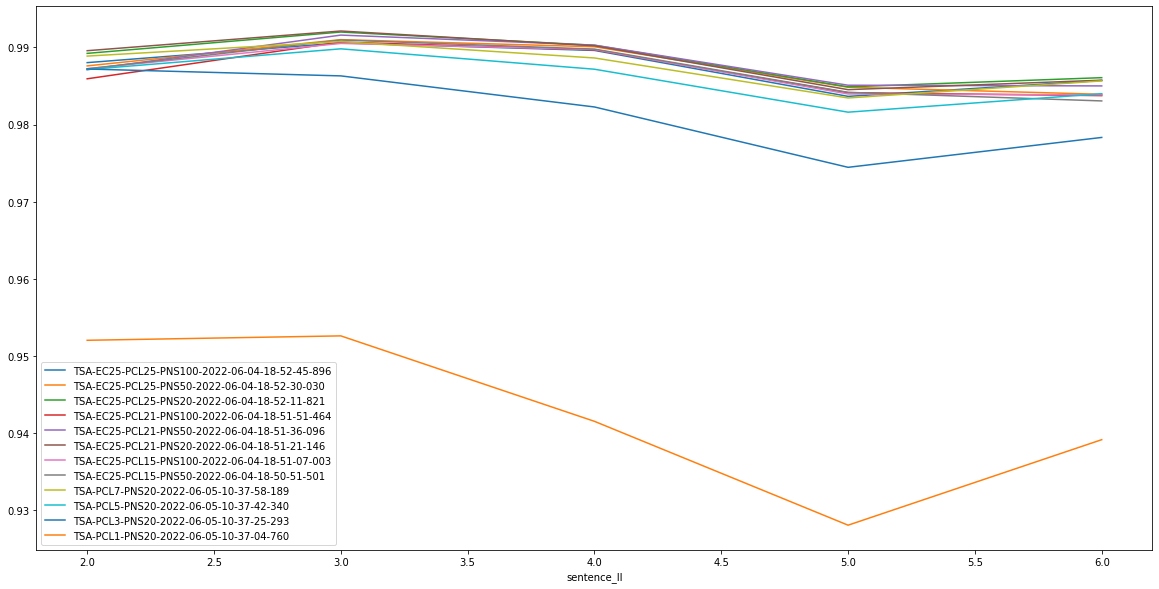

In [39]:
_, ax = plt.subplots(1,1,figsize=(20,10))
from tg.common.analysis import grbar_plot
rdf = pd.concat(rs)
rdf.transpose().plot(ax=ax)

In [70]:
src = pd.read_parquet(Loc.data_cache_path/'bundles/tsatsa/bundles/full/src.parquet', columns=[])

<AxesSubplot:xlabel='length'>

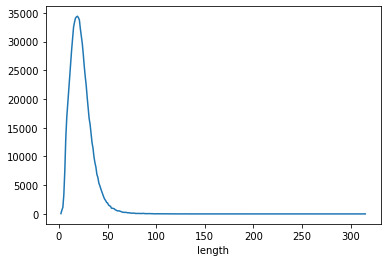

In [86]:
sz = src.groupby('sentence_id').size().to_frame('length')
sz.groupby('length').size().plot()

In [84]:
from tg.grammar_ru.common import DfViewer

DfViewer().convert(src.loc[src.sentence_id==sz.loc[sz.length>128].reset_index().iloc[7].sentence_id])